# Employee Performance Prediction

## 0 Libraries

### Importing dependencies



> Import the software library to be used in this project, including:



**1. Data Manipulation**

*   `pandas`, will be shortened as `pd`
*   `numpy`, will be shortened as `np`

**2. Data Visualization**

*   `matplotlib.pyplot`, will be shortened as `plt`
*   `seaborn`, will be shortened as `sns`

**3. Data Modelling**

*   `sklearn`
    *   `sklearn.mertics`
    *   `sklearn.model_selection`
    *   `sklearn.preprocessing`
    *   Model Linear Regression
    *   Model XGBoost









In [298]:
import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score, \
                            recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

plt.style.use("fivethirtyeight")

## 1 Data Loading

### Uploading the data into Jupyter Notebook

In [299]:
df = pd.read_csv('/content/In_class_data.txt')
df.head()

,candidate_id,source,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,notice_period_days,offer_accepted,interviewer_notes_keywords,probation_passed,performance_rating_6mo,performance_rating_12mo,tenure_months,high_performer_flag,voluntary_attrition
0,1,LinkedIn,5,Master,3.8,85,88,92,8.7,30,1,proactive leadership technical_expert,1,4.2,4.5,28,1,0.0
1,2,Referral,3,Bachelor,3.2,78,92,85,8.9,60,1,team_player enthusiastic cultural_fit,1,3.8,4.1,36,1,0.0
2,3,Indeed,2,Bachelor,3.0,65,72,68,6.5,15,1,requires_guidance limited_experience,1,2.8,3.0,6,0,1.0
3,4,Campus,0,Bachelor,3.6,82,75,78,7.8,45,1,quick_learner needs_training,1,3.5,4.0,24,1,0.0
4,5,LinkedIn,7,PhD,3.9,90,85,94,8.5,90,1,expert independent high_expectations,1,4.5,4.7,12,1,1.0


## 2 Exploratory Data Analysis (EDA)

### 2.1 Data Dictionary

📊 Dataset Features Reference - [Data Source](https://github.com/amathiday/Employee-Performance-Prediction/tree/main)

The dataset consists of 500 rows and 17 columns, coveriang a wide range of factors including:

1. Required Features (Prediction Inputs)
These features are mandatory for the model to generate a prediction:

| Column Name | Description | Value Range / Categories |
| :--- | :--- | :--- |
| `years_experience` | Number of years of professional work experience | Numeric |
| `gpa` | Grade Point Average | 0.0 - 4.0 |
| `tech_assessment` | Technical assessment score | 0 - 100 |
| `behavioral_assessment` | Behavioral assessment score | 0 - 100 |
| `coding_challenge` | Coding challenge score | 0 - 100 |
| `interview_score` | Average interview session score | 0 - 10 |
| `education_level` | Highest level of education attained | `High School`, `Bachelor`, `Master`, `PhD` |
| `source` | Candidate recruitment source | `Campus`, `Career_Fair`, `Company_Website`, `Indeed`, `LinkedIn`, `Referral` |

---

2. Optional / Output Features
These columns serve as metadata, target labels, or post-hiring performance data:

| Column Name | Description | Type / Scale |
| :--- | :--- | :--- |
| `candidate_id` | Unique identifier for each candidate | Unique String/ID |
| `notice_period_days` | Number of days for the notice period | Numeric |
| `offer_accepted` | Whether the job offer was accepted | Binary (0/1) |
| `interviewer_notes_keywords` | Key terms extracted from interviewer notes | String/Text |
| `probation_passed` | Whether the candidate passed the probation period | Binary (0/1) |
| `performance_rating_6mo` | Performance rating after 6 months | Numeric |
| `performance_rating_12mo` | Performance rating after 12 months | Numeric |
| `tenure_months` | Total length of employment in months | Numeric |
| `high_performer_flag` | Indicator for high-performing employees | Binary (0/1) |
| `voluntary_attrition` | Indicator for voluntary resignation | Binary (0/1) |

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   candidate_id                500 non-null    int64  
 1   source                      500 non-null    object 
 2   years_experience            500 non-null    int64  
 3   education_level             500 non-null    object 
 4   gpa                         500 non-null    float64
 5   tech_assessment             500 non-null    int64  
 6   behavioral_assessment       500 non-null    int64  
 7   coding_challenge            500 non-null    int64  
 8   interview_score             500 non-null    float64
 9   notice_period_days          500 non-null    int64  
 10  offer_accepted              500 non-null    int64  
 11  interviewer_notes_keywords  500 non-null    object 
 12  probation_passed            500 non-null    int64  
 13  performance_rating_6mo      483 non

### 2.2 Handling Missing Values

In [301]:
# Check missing values

nulls = df.isnull().sum()
nulls_percentage = nulls[nulls!=0]/df.shape[0]*100
print('Missing value percentage for each variable:\n')
print(round(nulls_percentage,2))

Missing value percentage for each variable:

performance_rating_6mo     3.4
performance_rating_12mo    8.6
voluntary_attrition        3.4
dtype: float64


In [302]:
df[df.isna().any(axis=1)]

,candidate_id,source,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,notice_period_days,offer_accepted,interviewer_notes_keywords,probation_passed,performance_rating_6mo,performance_rating_12mo,tenure_months,high_performer_flag,voluntary_attrition
9,10,LinkedIn,10,Bachelor,3.0,75,65,70,6.8,120,0,overqualified may_get_bored,0,NaN,NaN,0,0,NaN
11,12,Campus,0,Bachelor,2.9,60,75,65,6.0,60,1,struggling needs_support,0,2.5,NaN,3,0,1.0
26,27,Indeed,1,Bachelor,2.7,58,62,55,5.5,30,1,poor_preparation attitude_issues,0,2.0,NaN,2,0,1.0
47,48,Indeed,1,Bachelor,2.8,59,63,61,5.9,60,1,unfocused lacks_direction,0,2.1,NaN,3,0,1.0
48,49,LinkedIn,7,PhD,3.7,89,82,91,8.5,120,0,research_focused academic_career,0,NaN,NaN,0,0,NaN
69,70,Indeed,1,Bachelor,2.7,57,60,59,5.7,30,1,unprepared weak_candidate,0,2.0,NaN,2,0,1.0
83,84,Indeed,2,Bachelor,2.8,61,63,64,6.2,30,1,underperforming struggling,0,2.3,NaN,4,0,1.0
101,102,Indeed,1,Bachelor,2.7,56,61,58,5.6,30,1,poor_candidate not_recommended,0,1.9,NaN,2,0,1.0
123,124,Indeed,2,Bachelor,2.8,60,62,63,6.1,30,1,weak_candidate not_recommended,0,2.2,NaN,3,0,1.0
137,138,Indeed,2,Bachelor,2.9,61,63,64,6.3,30,1,underperforming struggles,0,2.4,NaN,4,0,1.0


In [303]:
# Impute missing values with a constant values

df_clean = df.copy()

df_clean['probation_failed'] = (df_clean['probation_passed'] == 0).astype(int)

df_clean['performance_rating_6mo'] = df_clean['performance_rating_6mo'].fillna(0)
df_clean['performance_rating_12mo'] = df_clean['performance_rating_12mo'].fillna(0)

df_clean['voluntary_attrition'] = df_clean['voluntary_attrition'].fillna(0)

print(f"Missing Values after cleaning: {df_clean.isnull().sum().sum()}")


Missing Values after cleaning: 0


In [304]:
# Check duplicated data

duplicates = df_clean.duplicated().sum()
print(f"Duplicated rows: {duplicates}")

Duplicated rows: 0


In [305]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   candidate_id                500 non-null    int64  
 1   source                      500 non-null    object 
 2   years_experience            500 non-null    int64  
 3   education_level             500 non-null    object 
 4   gpa                         500 non-null    float64
 5   tech_assessment             500 non-null    int64  
 6   behavioral_assessment       500 non-null    int64  
 7   coding_challenge            500 non-null    int64  
 8   interview_score             500 non-null    float64
 9   notice_period_days          500 non-null    int64  
 10  offer_accepted              500 non-null    int64  
 11  interviewer_notes_keywords  500 non-null    object 
 12  probation_passed            500 non-null    int64  
 13  performance_rating_6mo      500 non

In [306]:
# Check the columns that are numerical or categorical features

numerical_features = df_clean.select_dtypes(include="number").columns.tolist()
categorical_features = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical categories:")
print(numerical_features)
print("Categorical features:")
print(categorical_features)

Numerical categories:
['candidate_id', 'years_experience', 'gpa', 'tech_assessment', 'behavioral_assessment', 'coding_challenge', 'interview_score', 'notice_period_days', 'offer_accepted', 'probation_passed', 'performance_rating_6mo', 'performance_rating_12mo', 'tenure_months', 'high_performer_flag', 'voluntary_attrition', 'probation_failed']
Categorical features:
['source', 'education_level', 'interviewer_notes_keywords']


### 2.3 Summary Statistic

In [307]:
df_clean[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
candidate_id,500.0,250.5000,144.481833,1.0,125.750,250.5,375.25,500.0
years_experience,500.0,3.4700,2.303848,0.0,2.000,3.0,5.00,10.0
gpa,500.0,3.0496,0.570008,1.4,2.700,3.1,3.50,4.0
tech_assessment,500.0,72.6980,10.869549,46.0,65.000,73.0,81.25,95.0
behavioral_assessment,500.0,73.8040,9.681997,48.0,67.000,74.5,82.00,92.0
coding_challenge,500.0,74.7040,10.803788,49.0,67.000,75.0,83.25,96.0
interview_score,500.0,7.4092,0.952686,4.6,6.800,7.5,8.20,9.1
notice_period_days,500.0,42.6560,20.227406,14.0,30.000,30.0,60.00,120.0
offer_accepted,500.0,0.9660,0.181411,0.0,1.000,1.0,1.00,1.0
probation_passed,500.0,0.9140,0.280645,0.0,1.000,1.0,1.00,1.0


In [308]:
df_clean[categorical_features].describe().T

,count,unique,top,freq
source,500,6,LinkedIn,112
education_level,500,4,Bachelor,280
interviewer_notes_keywords,500,272,entry_level_raw potential_untapped,14


Based on the categorical summary statistics, **LinkedIn** is the primary recruitment source, and over half of the employees hold a **Bachelor's degree**.

### 2.4 EDA on Numerical Features

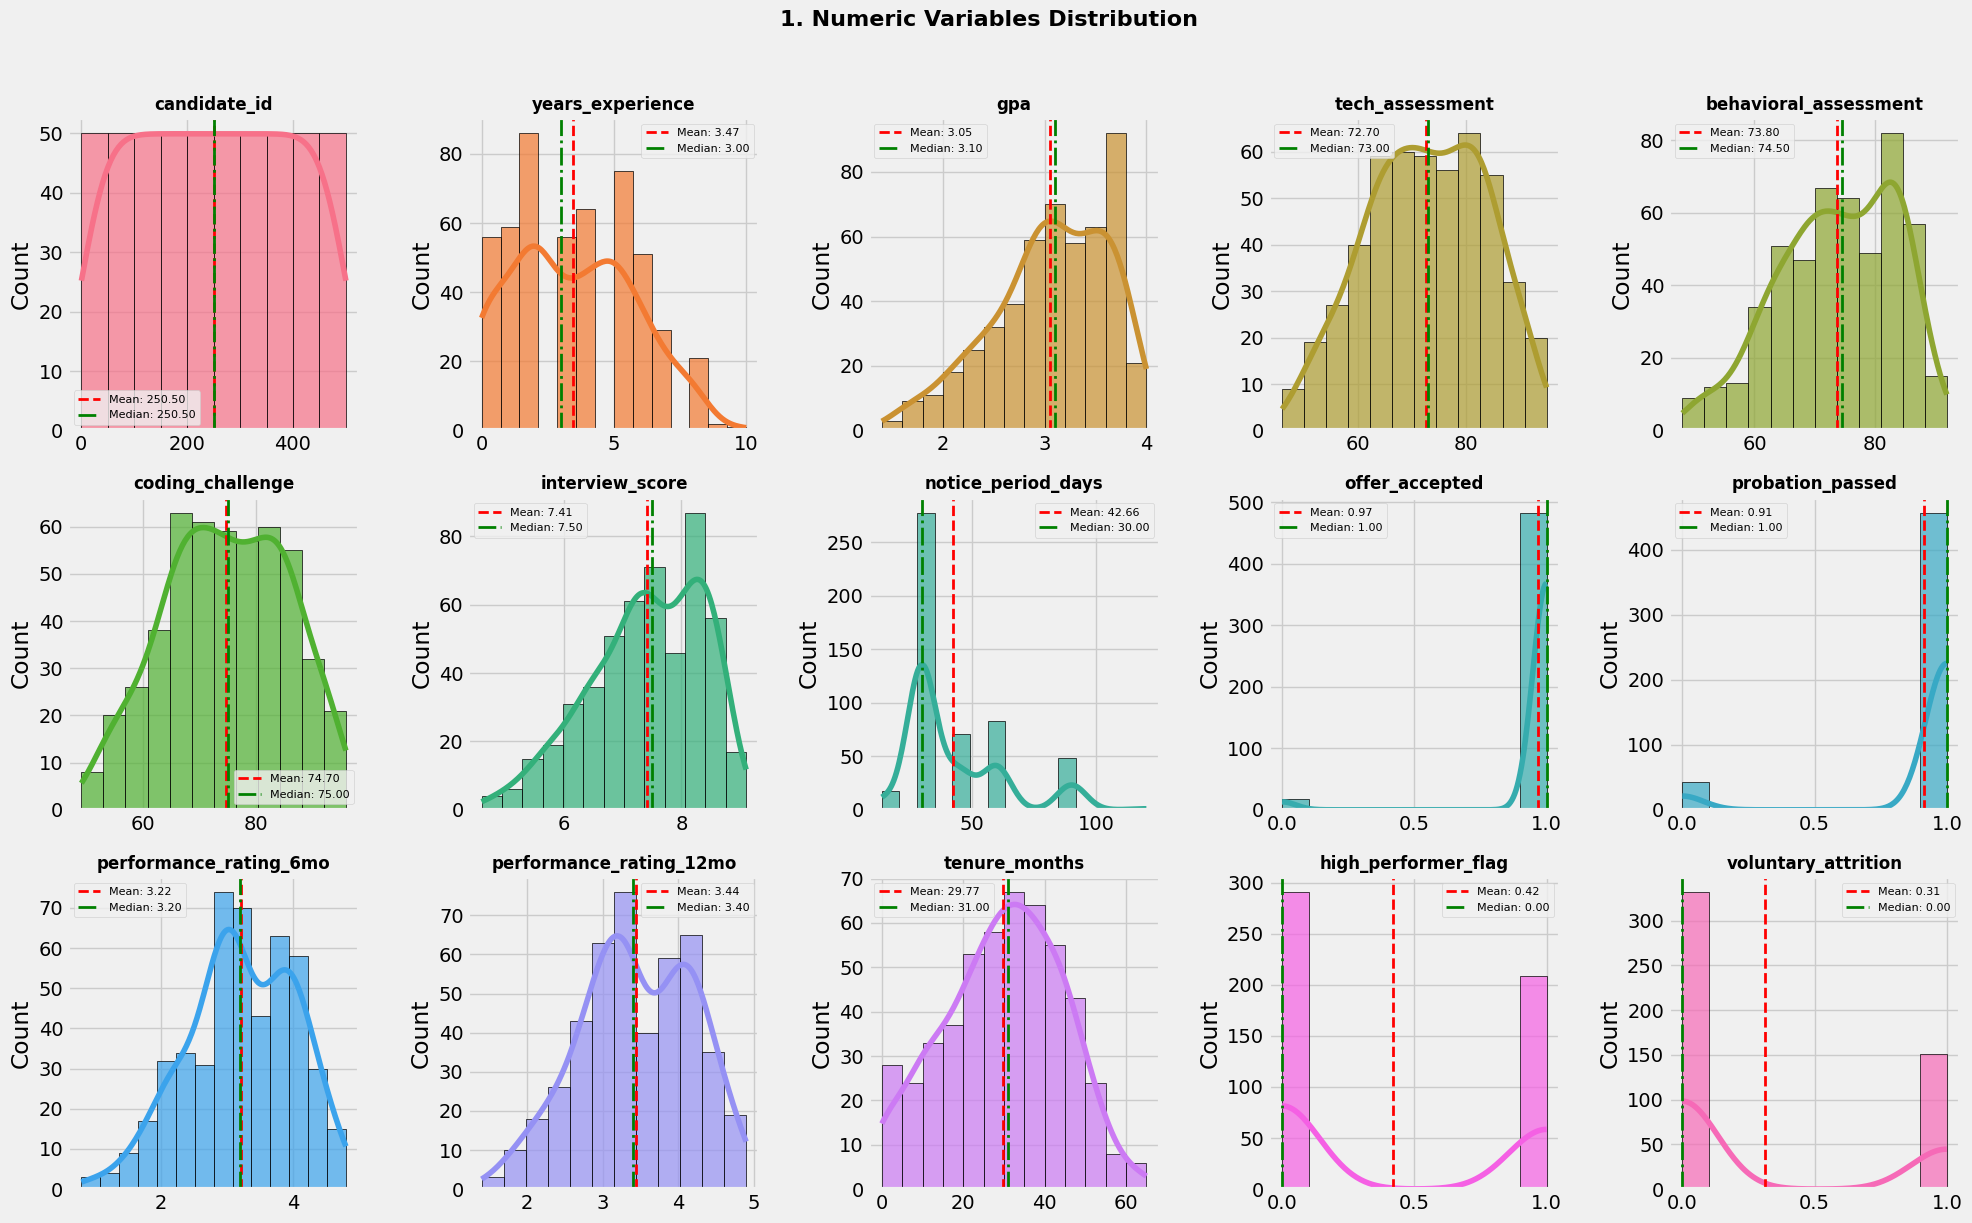

In [309]:
# Histograms of all numeric variables

def show_fig():
    plt.tight_layout()
    plt.show()

plot_no = 1

features_to_plot = [col for col in numerical_features if col in df.columns and col != 'probation_failed']

n_cols = 5
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax, color=sns.color_palette('husl', len(features_to_plot))[i],
                 edgecolor='black', alpha=0.7)

    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_val:.2f}')

    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.set_xlabel('')

for j in range(len(features_to_plot), len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f'{plot_no}. Numeric Variables Distribution', y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

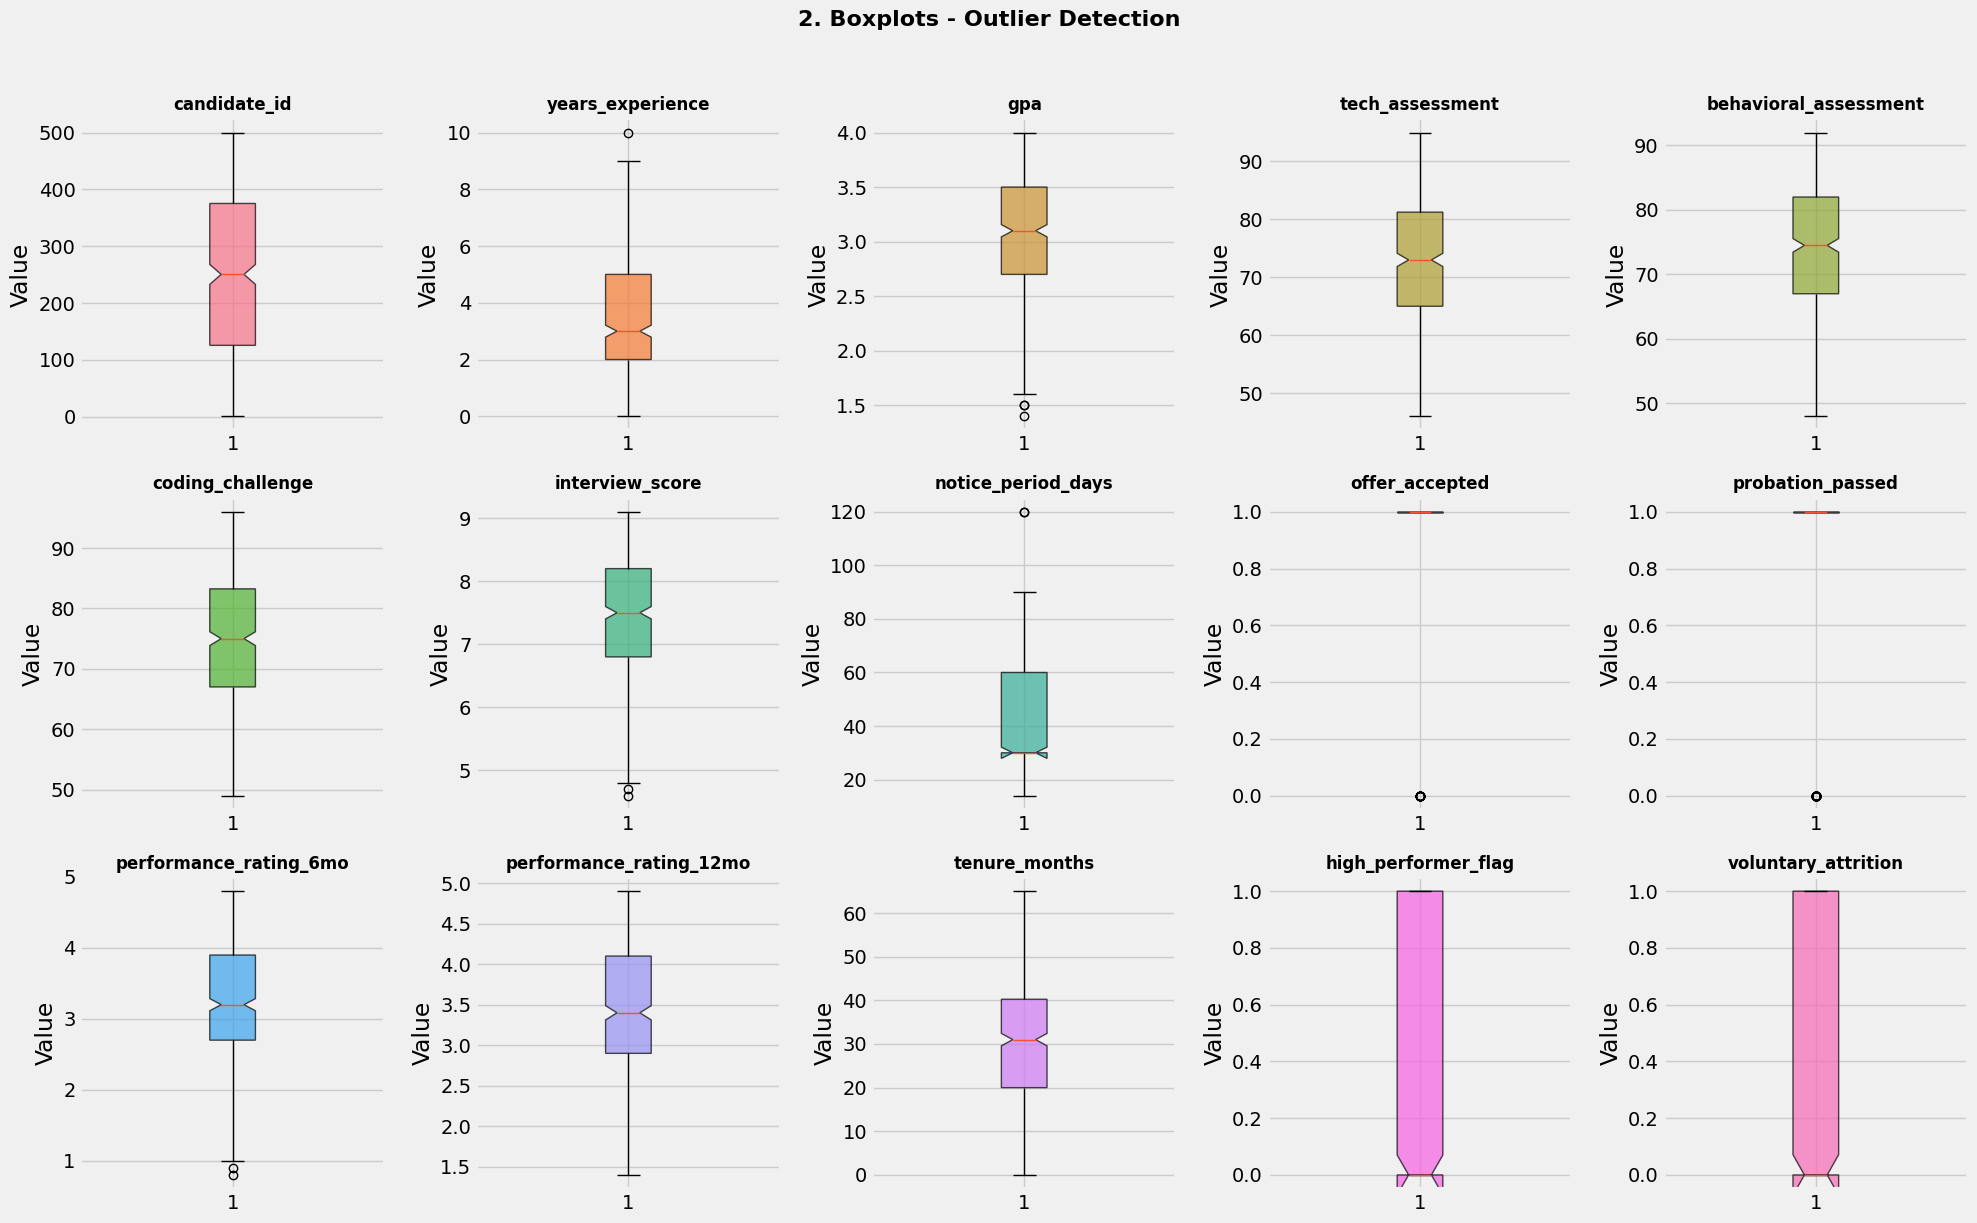

In [310]:
# Boxplots for outlier detection

n_cols = 5
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    bp = ax.boxplot(df[col].dropna(), patch_artist=True, notch=True)

    colors = sns.color_palette('husl', len(features_to_plot))
    bp['boxes'][0].set_facecolor(colors[i])
    bp['boxes'][0].set_alpha(0.7)

    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')

for j in range(len(features_to_plot), len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f'{plot_no}. Boxplots - Outlier Detection', y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

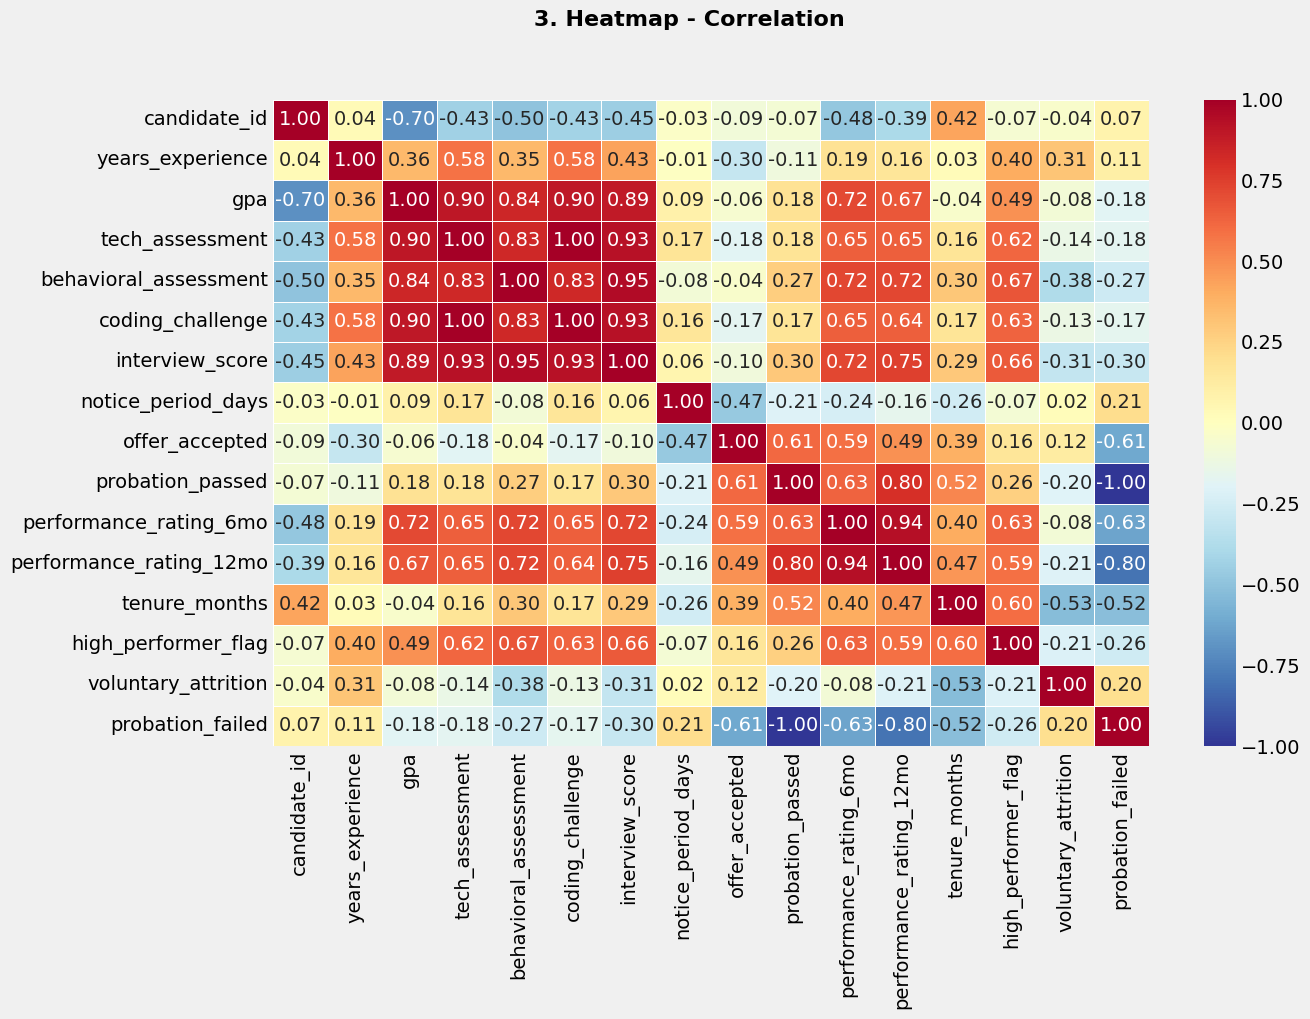

In [311]:
# Heatmeap for calculated correlation

correlation_matrix = df_clean[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', linewidths=.5, fmt=".2f")
plt.suptitle(f'{plot_no}. Heatmap - Correlation',
             y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

The heatmap shows that behavioral assessment, interview score, and coding challenge are the features **most strongly** correlated with being a high performer.

### 2.5 EDA on Categorical Features

In [312]:
# Check the distribution of categorical feature

for feature in categorical_features:
  print(df[feature].value_counts())
  print('-------')

source
LinkedIn           112
Referral           112
Indeed             110
Campus              56
Career_Fair         55
Company_Website     55
Name: count, dtype: int64
-------
education_level
Bachelor     280
Master       137
PhD           55
Associate     28
Name: count, dtype: int64
-------
interviewer_notes_keywords
entry_level_raw potential_untapped       14
average_student needs_guidance            9
fast_learner adaptive                     8
weak_performer struggles_basic            8
corporate_veteran process_expert          8
                                         ..
average_performer needs_support           1
experienced_mediocre plateaued_career     1
technical_leader architecture_skills      1
team_player collaboration_skills          1
reliable_performer consistent_output      1
Name: count, Length: 272, dtype: int64
-------


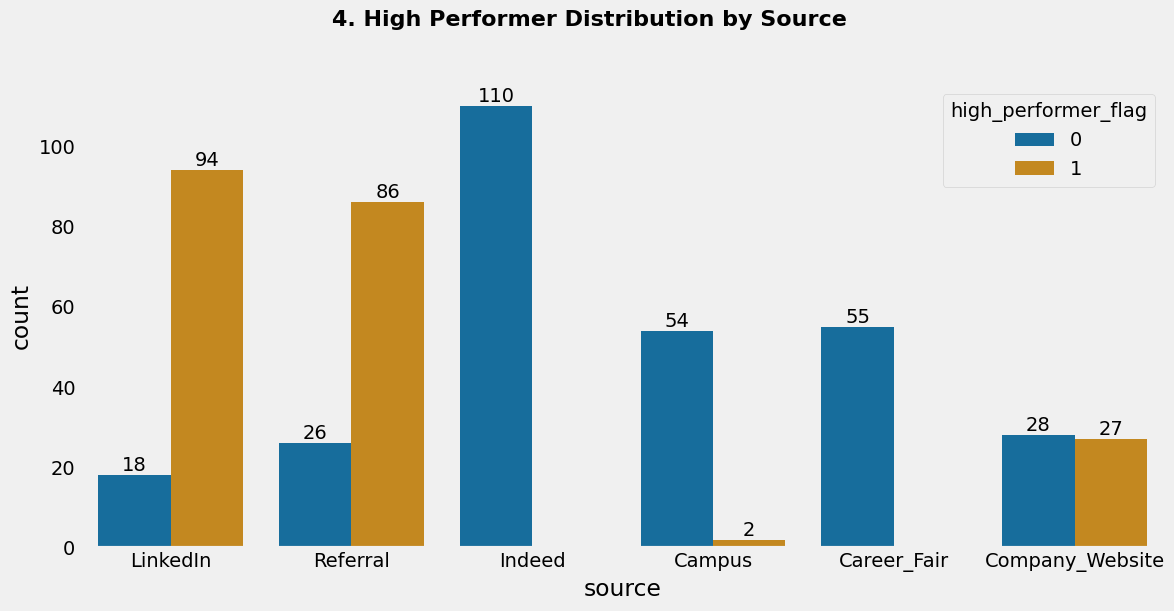

In [313]:
# Check the high performer distribution by source

source_order = df_clean["source"].value_counts().index
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='source',
    data=df_clean,
    order=source_order,
    palette="colorblind",
    hue="high_performer_flag"
)

for cont in ax.containers:
  ax.bar_label(cont)

plt.grid(False)
plt.suptitle(f'{plot_no}. High Performer Distribution by Source', y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

Employees sourced from LinkedIn and referrals represent the highest number of high performers.

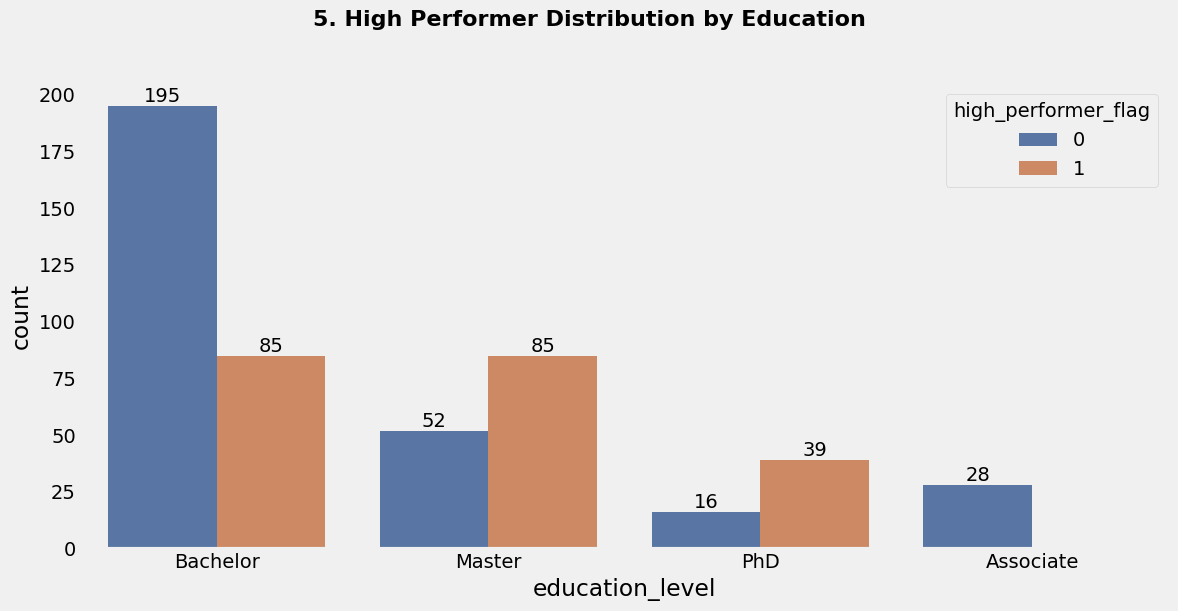

In [314]:
# Check the high performer distribution by education

education_level_order = df_clean["education_level"].value_counts().index
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='education_level',
    data=df_clean,
    order=education_level_order,
    palette="deep",
    hue="high_performer_flag"
)

for cont in ax.containers:
  ax.bar_label(cont)

plt.grid(False)
plt.suptitle(f'{plot_no}. High Performer Distribution by Education', y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

Most employees who hold a Master's or PhD are categorized as high performers.

## 3 Model Developmet

In [315]:
df_model = df_clean[df_clean['probation_passed'] == 1].copy()

In [316]:
df_model.head()

,candidate_id,source,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,notice_period_days,offer_accepted,interviewer_notes_keywords,probation_passed,performance_rating_6mo,performance_rating_12mo,tenure_months,high_performer_flag,voluntary_attrition,probation_failed
0,1,LinkedIn,5,Master,3.8,85,88,92,8.7,30,1,proactive leadership technical_expert,1,4.2,4.5,28,1,0.0,0
1,2,Referral,3,Bachelor,3.2,78,92,85,8.9,60,1,team_player enthusiastic cultural_fit,1,3.8,4.1,36,1,0.0,0
2,3,Indeed,2,Bachelor,3.0,65,72,68,6.5,15,1,requires_guidance limited_experience,1,2.8,3.0,6,0,1.0,0
3,4,Campus,0,Bachelor,3.6,82,75,78,7.8,45,1,quick_learner needs_training,1,3.5,4.0,24,1,0.0,0
4,5,LinkedIn,7,PhD,3.9,90,85,94,8.5,90,1,expert independent high_expectations,1,4.5,4.7,12,1,1.0,0


In [317]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   candidate_id                457 non-null    int64  
 1   source                      457 non-null    object 
 2   years_experience            457 non-null    int64  
 3   education_level             457 non-null    object 
 4   gpa                         457 non-null    float64
 5   tech_assessment             457 non-null    int64  
 6   behavioral_assessment       457 non-null    int64  
 7   coding_challenge            457 non-null    int64  
 8   interview_score             457 non-null    float64
 9   notice_period_days          457 non-null    int64  
 10  offer_accepted              457 non-null    int64  
 11  interviewer_notes_keywords  457 non-null    object 
 12  probation_passed            457 non-null    int64  
 13  performance_rating_6mo      457 non-null

In [318]:
# Remove features not related to our predictive model

df_model = df_model.drop(['candidate_id','interviewer_notes_keywords', 'notice_period_days',
                     'offer_accepted', 'probation_passed','performance_rating_6mo', 'performance_rating_12mo',
                          'tenure_months', 'voluntary_attrition', 'probation_failed'], axis=1)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   source                 457 non-null    object 
 1   years_experience       457 non-null    int64  
 2   education_level        457 non-null    object 
 3   gpa                    457 non-null    float64
 4   tech_assessment        457 non-null    int64  
 5   behavioral_assessment  457 non-null    int64  
 6   coding_challenge       457 non-null    int64  
 7   interview_score        457 non-null    float64
 8   high_performer_flag    457 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 35.7+ KB


In [319]:
# mapping features of education
edu_map = {'Associate': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}

# apply mapping to dataframe
df_model['education_level'] = df_model['education_level'].map(edu_map)

# check type of data education and attrition
print(df_model['education_level'].dtype)

# check, is the two features have null data
print(df_model['education_level'].isna().sum())

int64
0


In [320]:
df_model.head()

,source,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,high_performer_flag
0,LinkedIn,5,2,3.8,85,88,92,8.7,1
1,Referral,3,1,3.2,78,92,85,8.9,1
2,Indeed,2,1,3.0,65,72,68,6.5,0
3,Campus,0,1,3.6,82,75,78,7.8,1
4,LinkedIn,7,3,3.9,90,85,94,8.5,1


In [321]:
numerical_features = df_model.select_dtypes(include="number").columns.tolist()
if "high_performer_flag" in numerical_features:
    numerical_features.remove("high_performer_flag")
categorical_features = df_model.select_dtypes(include="object").columns.tolist()

print("Numerical categories:")
print(numerical_features)
print("Categorical features:")
print(categorical_features)

Numerical categories:
['years_experience', 'education_level', 'gpa', 'tech_assessment', 'behavioral_assessment', 'coding_challenge', 'interview_score']
Categorical features:
['source']


In [322]:
# Define variable X (independent variable/features)
X = df_model.drop(columns=["high_performer_flag"]).copy()

# Define varibel Y (dependent variable/features)
y = df_model["high_performer_flag"].copy()

### 3.1 Data Spliting

In [323]:
# create for each set

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=42)

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 365 (79.869%)
dev size: 46 (10.066%)
test size: 46 (10.066%)


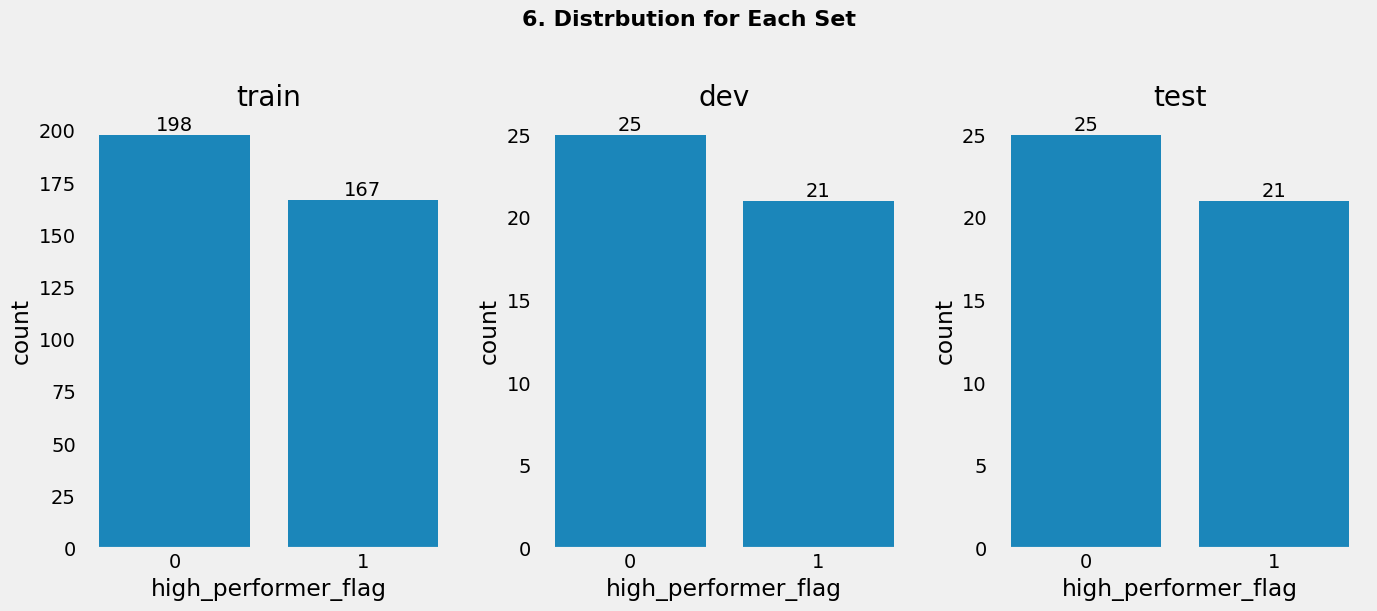

In [324]:
# check the distrubition for each set

fig, axis = plt.subplots(1, 3, figsize=(14, 6))

for idx, (data, title) in enumerate([
    (y_train, "train"), (y_dev, "dev"), (y_test, "test")
]):
    sns.countplot(x=data, ax=axis[idx])

    for container in axis[idx].containers:
        axis[idx].bar_label(container)

    axis[idx].set_title(title)
    axis[idx].grid(False)

plt.tight_layout()
plt.suptitle(f'{plot_no}. Distrbution for Each Set', y=1.02, fontsize=16, fontweight='bold')
show_fig()
plot_no += 1

### 3.2 Categorical Encoding

In [325]:
# Encoding on nominal features
onehot = OneHotEncoder()
onehot.fit(X_train[categorical_features])
X_train_onehot = pd.DataFrame(
    onehot.transform(X_train[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_dev_onehot = pd.DataFrame(
    onehot.transform(X_dev[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_test_onehot = pd.DataFrame(
    onehot.transform(X_test[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(X_train_onehot)

one-hot matrix:


,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
360,0.0,0.0,0.0,0.0,1.0,0.0
361,1.0,0.0,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,1.0,0.0,0.0
363,0.0,1.0,0.0,0.0,0.0,0.0


### 3.3 Data Rescaling

In [326]:
# Combining DataFrames using the pandas function pd
X_train_combined = pd.concat(
    [X_train[numerical_features].reset_index(drop=True), X_train_onehot],
    axis=1
)
X_dev_combined = pd.concat(
    [X_dev[numerical_features].reset_index(drop=True), X_dev_onehot],
    axis=1
)
X_test_combined = pd.concat(
    [X_test[numerical_features].reset_index(drop=True), X_test_onehot],
    axis=1
)

X_train_combined.head()

,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,2,1,2.9,63,61,65,6.2,0.0,0.0,0.0,1.0,0.0,0.0
1,6,2,3.5,83,81,85,8.2,0.0,0.0,1.0,0.0,0.0,0.0
2,4,2,3.8,87,85,89,8.5,0.0,0.0,0.0,0.0,1.0,0.0
3,4,2,3.7,86,84,87,8.3,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,2.1,60,68,62,6.9,0.0,0.0,0.0,0.0,0.0,1.0


In [327]:
# Call the StandardScaler function from the scikit-learn package
scaler = StandardScaler()
scaler.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_combined),
    columns=X_train_combined.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev_combined),
    columns=X_dev_combined.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,-0.641623,-0.555584,-0.368261,-1.030124,-1.459188,-1.028613,-1.513767,-0.375,-0.340893,-0.365432,1.950034,-0.508548,-0.563640
1,1.109349,0.823927,0.723067,0.929716,0.687974,0.935005,0.796603,-0.375,-0.340893,2.736489,-0.512812,-0.508548,-0.563640
2,0.233863,0.823927,1.268731,1.321684,1.117407,1.327729,1.143158,-0.375,-0.340893,-0.365432,-0.512812,1.966384,-0.563640
3,0.233863,0.823927,1.086843,1.223692,1.010049,1.131367,0.912121,-0.375,-0.340893,2.736489,-0.512812,-0.508548,-0.563640
4,-1.079366,-0.555584,-1.823365,-1.324100,-0.707681,-1.323156,-0.705138,-0.375,-0.340893,-0.365432,-0.512812,-0.508548,1.774184


### 3.4 Modelling - Iteration 1

#### Logistic Regression

Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.95      1.00      0.98        21

    accuracy                           0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46

Calculation Specific Result:

Correctly Predicted 'No' (TN): 24
Incorrectly Predicted 'No' (FP): 1
Incorrectly Predicted 'Yes' (FN): 0
Correctly Predicted 'Yes' (TP): 21


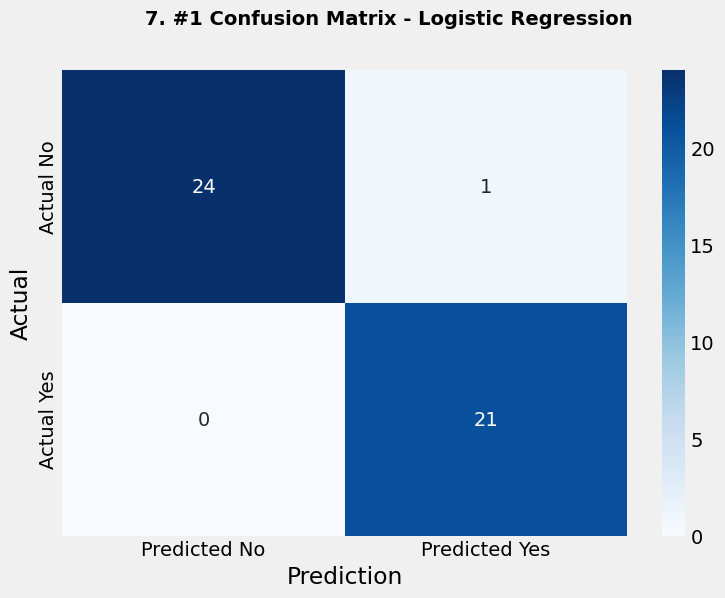

In [328]:
# Call the LogisticRegression function from the scikit-learn package
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_log = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_log)

# Evaluation
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))

print("="*60)

# Performance Metrics Detail
print("Calculation Specific Result:\n")
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #1 Confusion Matrix - Logistic Regression', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1


In [329]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': log_model.coef_[0]
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                   Feature    Weight
3          tech_assessment  1.525780
0         years_experience  1.322045
12         source_Referral  1.312522
5         coding_challenge  1.057268
4    behavioral_assessment  0.646857
11         source_LinkedIn  0.603592
1          education_level  0.602498
6          interview_score  0.497626
7            source_Campus  0.077561
8       source_Career_Fair -0.302367
9   source_Company_Website -0.651637
10           source_Indeed -1.301347
2                      gpa -1.712517


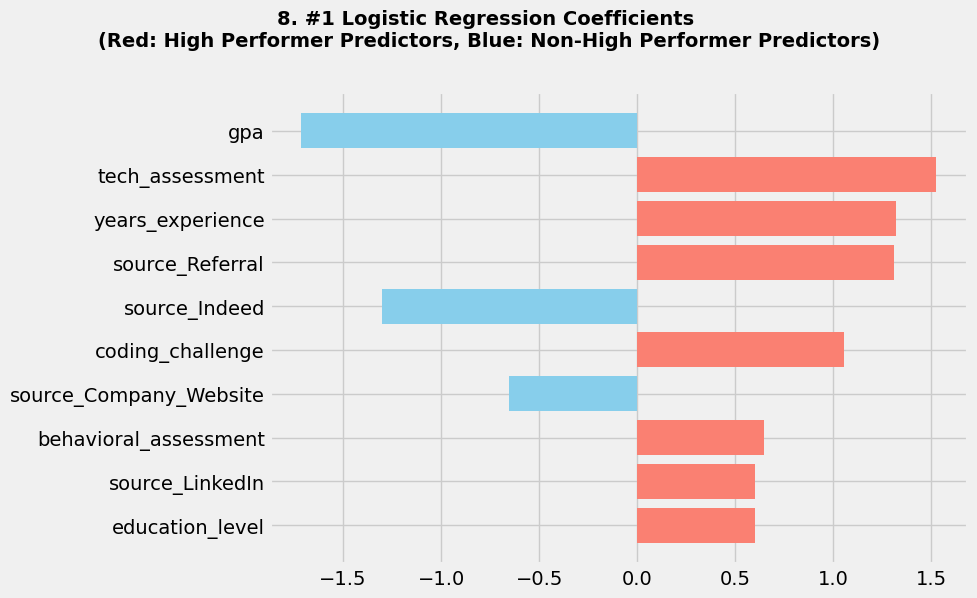

In [330]:
# Create visualisastion of logistic regression coefficients
log_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_model.coef_[0]
})

# Sort by largest absolute influence
log_importance['abs_coeff'] = log_importance['Coefficient'].abs()
log_importance = log_importance.sort_values(by='abs_coeff', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(log_importance['Feature'], log_importance['Coefficient'],
         color=(log_importance['Coefficient'] > 0).map({True: 'salmon', False: 'skyblue'}))
plt.suptitle(f'{plot_no}. #1 Logistic Regression Coefficients \n(Red: High Performer Predictors, Blue: Non-High Performer Predictors)', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [331]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.91780822 0.94520548 0.89041096 0.95890411 0.93150685]
Average Accuracy: 92.88%
Standard Deviation (Consistency): 2.36%


#### XGBoost Algorithm

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.95      1.00      0.98        21

    accuracy                           0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46

Result Calculation Specific:

Correctly Predicted 'No' (TN): 24
Incorrectly Predicted 'No' (FP): 1
Incorrectly Predicted 'Yes' (FN): 0
Correctly Predicted 'Yes' (TP): 21


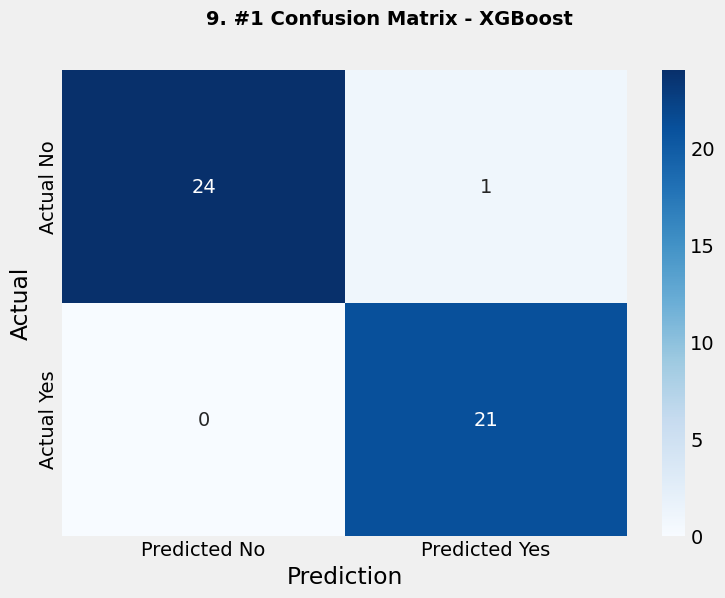

In [332]:
# Call the XGBClassifier function
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

# Training Model
xgb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

print("="*60)

# Performance Metrics Detail
print("Result Calculation Specific:\n")
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #1 Confusion Matrix - XGBoost', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [333]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': xgb_model.feature_importances_
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                   Feature    Weight
6          interview_score  0.350377
4    behavioral_assessment  0.124049
11         source_LinkedIn  0.116335
12         source_Referral  0.096725
0         years_experience  0.076104
9   source_Company_Website  0.061266
1          education_level  0.051939
3          tech_assessment  0.039891
8       source_Career_Fair  0.024191
5         coding_challenge  0.021416
10           source_Indeed  0.021097
2                      gpa  0.016611
7            source_Campus  0.000000


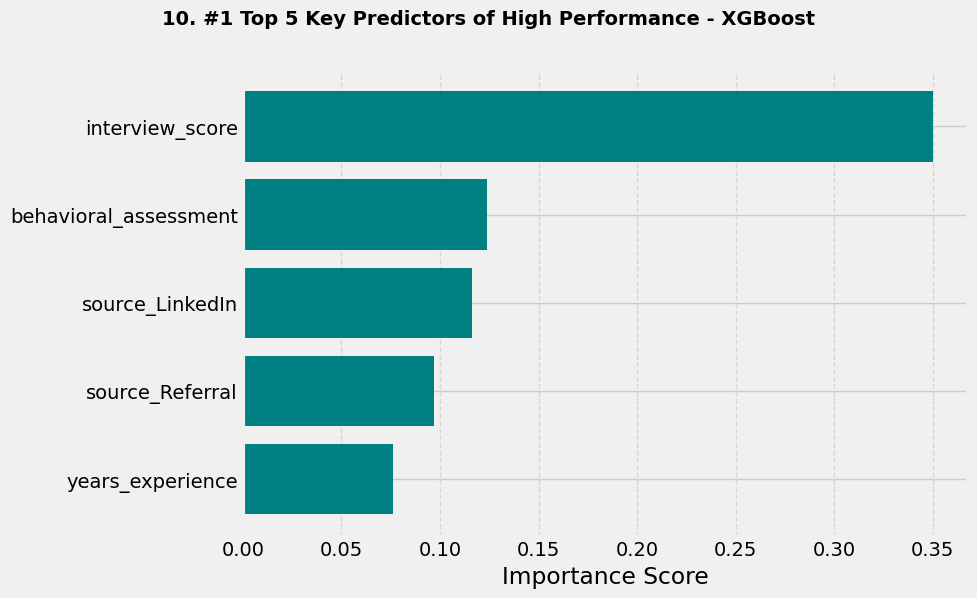

In [334]:
# Create visaulization top 5 key predictor of high performer
selected_model = xgb_model

# Taking the feature importance score
importances = selected_model.feature_importances_
feature_names = X_train_scaled.columns

# Create a DataFrame to make sorting easier
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importance = df_importance.sort_values(by='Importance', ascending=True).tail(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.suptitle(f'{plot_no}. #1 Top 5 Key Predictors of High Performance - XGBoost', y=1, fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
show_fig()
plot_no += 1

In [335]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.97260274 0.98630137 0.94520548 0.98630137 0.98630137]
Average Accuracy: 97.53%
Standard Deviation (Consistency): 1.60%


####Evaluation

⚠️ Note on Data Leakage: The initial 98% accuracy indicates potential Data Leakage, as the model relies too heavily on "proxy" features. To ensure the model learns deeper behavioral patterns and remains objective, these high-weight features will be dropped in the next iteration. This step is crucial to improve generalization predictors.

### 3.5 Modelling - Iteration 2

In [336]:
# importance features on logistic regression model
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': log_model.coef_[0]
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                   Feature    Weight
3          tech_assessment  1.525780
0         years_experience  1.322045
12         source_Referral  1.312522
5         coding_challenge  1.057268
4    behavioral_assessment  0.646857
11         source_LinkedIn  0.603592
1          education_level  0.602498
6          interview_score  0.497626
7            source_Campus  0.077561
8       source_Career_Fair -0.302367
9   source_Company_Website -0.651637
10           source_Indeed -1.301347
2                      gpa -1.712517


In [337]:
# importance features on XGBoost model
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': xgb_model.feature_importances_
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                   Feature    Weight
6          interview_score  0.350377
4    behavioral_assessment  0.124049
11         source_LinkedIn  0.116335
12         source_Referral  0.096725
0         years_experience  0.076104
9   source_Company_Website  0.061266
1          education_level  0.051939
3          tech_assessment  0.039891
8       source_Career_Fair  0.024191
5         coding_challenge  0.021416
10           source_Indeed  0.021097
2                      gpa  0.016611
7            source_Campus  0.000000


In [338]:
# drop interview score, tech assessment & years experiance features
df_model2 = df_model.drop([ 'interview_score', 'tech_assessment', 'years_experience'], axis=1).copy()
df_model2.info()
df_model2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 457 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   source                 457 non-null    object 
 1   education_level        457 non-null    int64  
 2   gpa                    457 non-null    float64
 3   behavioral_assessment  457 non-null    int64  
 4   coding_challenge       457 non-null    int64  
 5   high_performer_flag    457 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 25.0+ KB


,source,education_level,gpa,behavioral_assessment,coding_challenge,high_performer_flag
0,LinkedIn,2,3.8,88,92,1
1,Referral,1,3.2,92,85,1
2,Indeed,1,3.0,72,68,0
3,Campus,1,3.6,75,78,1
4,LinkedIn,3,3.9,85,94,1


#### Preparation data model

In [339]:
# Check the columns that are numerical or categorical features
numerical_features = df_model2.select_dtypes(include="number").columns.tolist()
if "high_performer_flag" in numerical_features:
    numerical_features.remove("high_performer_flag")
categorical_features = df_model2.select_dtypes(include="object").columns.tolist()

print("Numerical categories:")
print(numerical_features)
print("Categorical features:")
print(categorical_features)

Numerical categories:
['education_level', 'gpa', 'behavioral_assessment', 'coding_challenge']
Categorical features:
['source']


In [340]:
# Define variable X (independent variable/features)
X = df_model2.drop(columns=["high_performer_flag"]).copy()

# Define varibel Y (dependent variable/features)
y = df_model2["high_performer_flag"].copy()

In [341]:
# create for each set

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=42)

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 365 (79.869%)
dev size: 46 (10.066%)
test size: 46 (10.066%)


In [342]:
# Encoding on nominal features
onehot = OneHotEncoder()
onehot.fit(X_train[categorical_features])
X_train_onehot = pd.DataFrame(
    onehot.transform(X_train[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_dev_onehot = pd.DataFrame(
    onehot.transform(X_dev[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_test_onehot = pd.DataFrame(
    onehot.transform(X_test[categorical_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(X_train_onehot)

one-hot matrix:


,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
360,0.0,0.0,0.0,0.0,1.0,0.0
361,1.0,0.0,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,1.0,0.0,0.0
363,0.0,1.0,0.0,0.0,0.0,0.0


In [343]:
# Combining DataFrames using the pandas function pd
X_train_combined = pd.concat(
    [X_train[numerical_features].reset_index(drop=True), X_train_onehot],
    axis=1
)
X_dev_combined = pd.concat(
    [X_dev[numerical_features].reset_index(drop=True), X_dev_onehot],
    axis=1
)
X_test_combined = pd.concat(
    [X_test[numerical_features].reset_index(drop=True), X_test_onehot],
    axis=1
)

X_train_combined.head()

,education_level,gpa,behavioral_assessment,coding_challenge,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,1,2.9,61,65,0.0,0.0,0.0,1.0,0.0,0.0
1,2,3.5,81,85,0.0,0.0,1.0,0.0,0.0,0.0
2,2,3.8,85,89,0.0,0.0,0.0,0.0,1.0,0.0
3,2,3.7,84,87,0.0,0.0,1.0,0.0,0.0,0.0
4,1,2.1,68,62,0.0,0.0,0.0,0.0,0.0,1.0


In [344]:
# Call the StandardScaler function from the scikit-learn package
scaler = StandardScaler()
scaler.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_combined),
    columns=X_train_combined.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev_combined),
    columns=X_dev_combined.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,education_level,gpa,behavioral_assessment,coding_challenge,source_Campus,source_Career_Fair,source_Company_Website,source_Indeed,source_LinkedIn,source_Referral
0,-0.555584,-0.368261,-1.459188,-1.028613,-0.375,-0.340893,-0.365432,1.950034,-0.508548,-0.563640
1,0.823927,0.723067,0.687974,0.935005,-0.375,-0.340893,2.736489,-0.512812,-0.508548,-0.563640
2,0.823927,1.268731,1.117407,1.327729,-0.375,-0.340893,-0.365432,-0.512812,1.966384,-0.563640
3,0.823927,1.086843,1.010049,1.131367,-0.375,-0.340893,2.736489,-0.512812,-0.508548,-0.563640
4,-0.555584,-1.823365,-0.707681,-1.323156,-0.375,-0.340893,-0.365432,-0.512812,-0.508548,1.774184


#### Logistic Regression

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.87      0.95      0.91        21

    accuracy                           0.91        46
   macro avg       0.91      0.92      0.91        46
weighted avg       0.92      0.91      0.91        46

Calculation Specific Result:

Correctly Predicted 'No' (TN): 22
Incorrectly Predicted 'No' (FP): 3
Incorrectly Predicted 'Yes' (FN): 1
Correctly Predicted 'Yes' (TP): 20


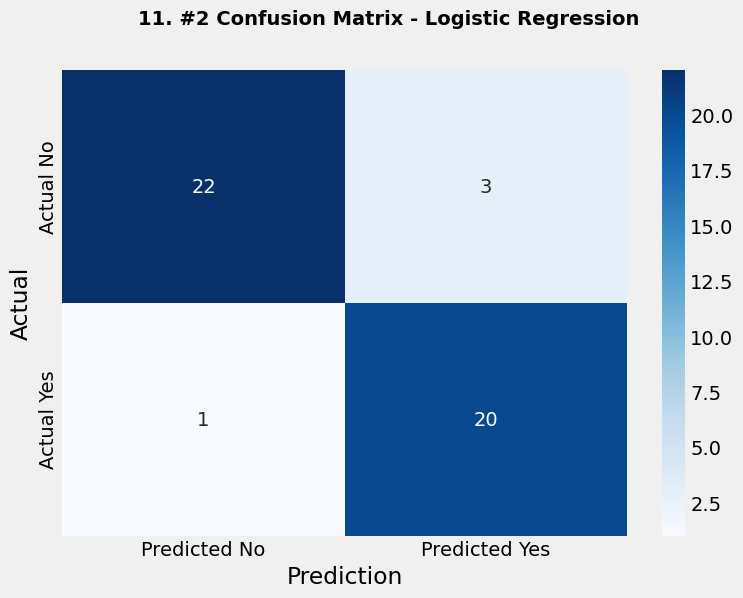

In [345]:
# Call the LogisticRegression function from the scikit-learn package
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_log = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_log)

# Evaluation
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))

print("="*60)

# Performance Metrics Detail
print("Calculation Specific Result:\n")
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #2 Confusion Matrix - Logistic Regression', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [346]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': log_model.coef_[0]
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                  Feature    Weight
3        coding_challenge  2.268589
2   behavioral_assessment  1.346137
9         source_Referral  0.925764
8         source_LinkedIn  0.911329
0         education_level  0.714369
6  source_Company_Website -0.243428
4           source_Campus -0.434724
5      source_Career_Fair -0.550058
7           source_Indeed -0.923147
1                     gpa -1.652197


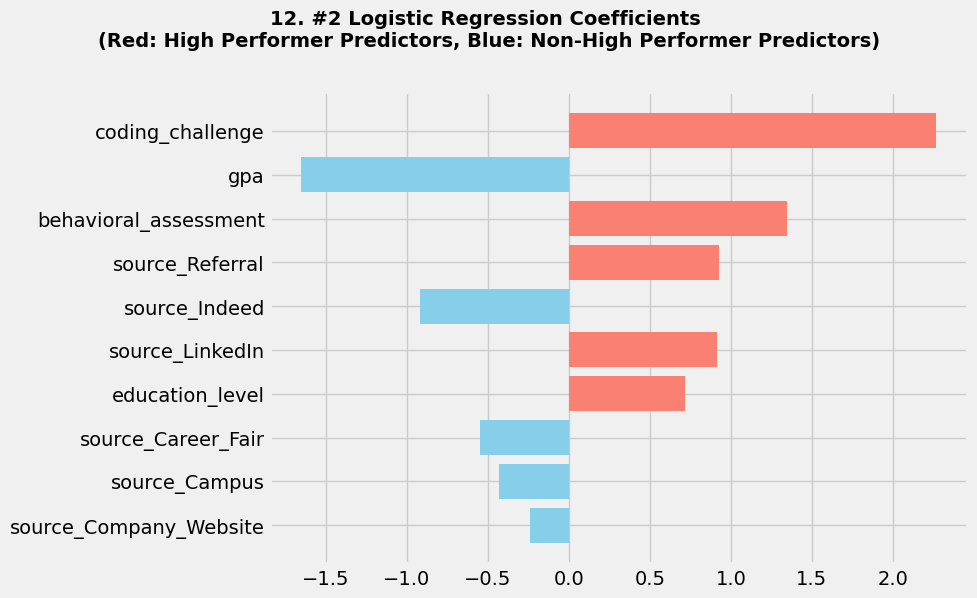

In [347]:
# Create visualisastion of logistic regression coefficients
log_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_model.coef_[0]
})

# Sort by largest absolute influence
log_importance['abs_coeff'] = log_importance['Coefficient'].abs()
log_importance = log_importance.sort_values(by='abs_coeff', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(log_importance['Feature'], log_importance['Coefficient'],
         color=(log_importance['Coefficient'] > 0).map({True: 'salmon', False: 'skyblue'}))
plt.suptitle(f'{plot_no}. #2 Logistic Regression Coefficients \n(Red: High Performer Predictors, Blue: Non-High Performer Predictors)', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [348]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.91780822 0.90410959 0.89041096 0.93150685 0.91780822]
Average Accuracy: 91.23%
Standard Deviation (Consistency): 1.40%


#### XGBoost Algorithm

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.82      0.86      0.84        21

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46

Result Calculation Specific:

Correctly Predicted 'No' (TN): 21
Incorrectly Predicted 'No' (FP): 4
Incorrectly Predicted 'Yes' (FN): 3
Correctly Predicted 'Yes' (TP): 18


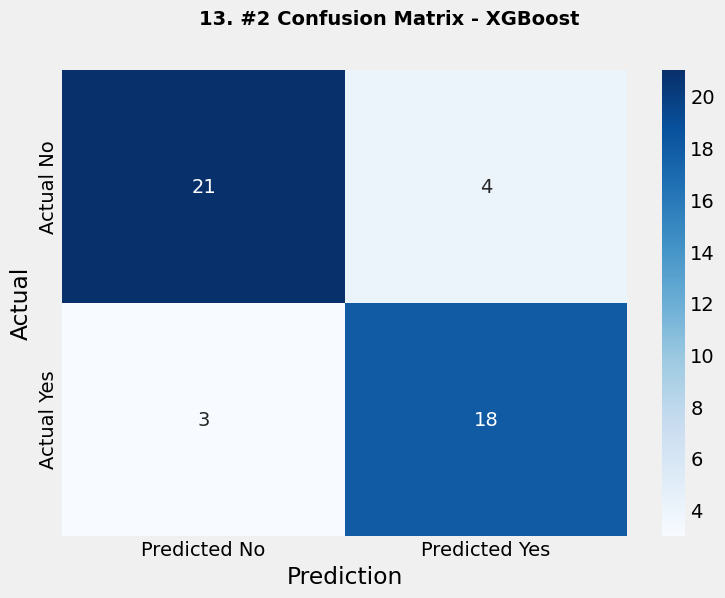

In [349]:
# Call the XGBClassifier function
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

# Training Model
xgb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

print("="*60)

# Performance Metrics Detail
print("Result Calculation Specific:\n")
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #2 Confusion Matrix - XGBoost', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [350]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': xgb_model.feature_importances_
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                  Feature    Weight
5      source_Career_Fair  0.304947
2   behavioral_assessment  0.173429
9         source_Referral  0.137634
8         source_LinkedIn  0.101974
3        coding_challenge  0.084181
6  source_Company_Website  0.070003
0         education_level  0.063550
1                     gpa  0.039944
7           source_Indeed  0.024339
4           source_Campus  0.000000


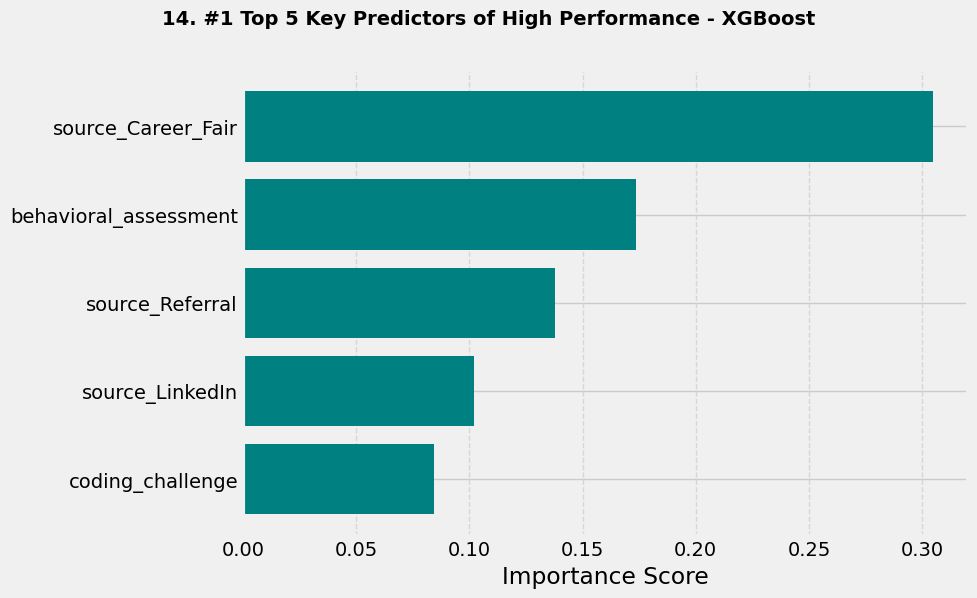

In [351]:
# Create visaulization top 5 key predictor of high performer
selected_model = xgb_model

# Taking the feature importance score
importances = selected_model.feature_importances_
feature_names = X_train_scaled.columns

# Create a DataFrame to make sorting easier
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importance = df_importance.sort_values(by='Importance', ascending=True).tail(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.suptitle(f'{plot_no}. #1 Top 5 Key Predictors of High Performance - XGBoost', y=1, fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
show_fig()
plot_no += 1

In [352]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.90410959 0.89041096 0.89041096 0.94520548 0.90410959]
Average Accuracy: 90.68%
Standard Deviation (Consistency): 2.01%


### 3.6 Modelling - Iteration 3

⚖️ Ethical Refinement: In this final iteration, the source feature (recruitment channel) is dropped to ensure a merit-based and ethical model. While recruitment channels may show statistical correlation, they are not causal drivers of performance. Removing this feature prevents systemic bias and forces the model to rely solely on individual competencies, resulting in a more robust and fair prediction.

In [353]:
# drop feature source
df_model3 = df_model.drop(['source'], axis=1).copy()
df_model3.info()
df_model3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 457 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   years_experience       457 non-null    int64  
 1   education_level        457 non-null    int64  
 2   gpa                    457 non-null    float64
 3   tech_assessment        457 non-null    int64  
 4   behavioral_assessment  457 non-null    int64  
 5   coding_challenge       457 non-null    int64  
 6   interview_score        457 non-null    float64
 7   high_performer_flag    457 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 32.1 KB


,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score,high_performer_flag
0,5,2,3.8,85,88,92,8.7,1
1,3,1,3.2,78,92,85,8.9,1
2,2,1,3.0,65,72,68,6.5,0
3,0,1,3.6,82,75,78,7.8,1
4,7,3,3.9,90,85,94,8.5,1


#### Preparation data model

In [354]:
# Check the columns that are numerical or categorical features
numerical_features = df_model3.select_dtypes(include="number").columns.tolist()
if "high_performer_flag" in numerical_features:
    numerical_features.remove("high_performer_flag")
categorical_features = df_model3.select_dtypes(include="object").columns.tolist()

print("Numerical categories:")
print(numerical_features)
print("Categorical features:")
print(categorical_features)

Numerical categories:
['years_experience', 'education_level', 'gpa', 'tech_assessment', 'behavioral_assessment', 'coding_challenge', 'interview_score']
Categorical features:
[]


In [355]:
# Define variable X (independent variable/features)
X = df_model3.drop(columns=["high_performer_flag"]).copy()

# Define varibel Y (dependent variable/features)
y = df_model3["high_performer_flag"].copy()

In [356]:
# create for each set

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=42)

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 365 (79.869%)
dev size: 46 (10.066%)
test size: 46 (10.066%)


In [357]:
# # Call the StandardScaler function from the scikit-learn package
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev),
    columns=X_dev.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,years_experience,education_level,gpa,tech_assessment,behavioral_assessment,coding_challenge,interview_score
0,-0.641623,-0.555584,-0.368261,-1.030124,-1.459188,-1.028613,-1.513767
1,1.109349,0.823927,0.723067,0.929716,0.687974,0.935005,0.796603
2,0.233863,0.823927,1.268731,1.321684,1.117407,1.327729,1.143158
3,0.233863,0.823927,1.086843,1.223692,1.010049,1.131367,0.912121
4,-1.079366,-0.555584,-1.823365,-1.324100,-0.707681,-1.323156,-0.705138


#### Logistic Regression

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.87      0.95      0.91        21

    accuracy                           0.91        46
   macro avg       0.91      0.92      0.91        46
weighted avg       0.92      0.91      0.91        46

Calculation Specific Result:

Correctly Predicted 'No' (TN): 22
Incorrectly Predicted 'No' (FP): 3
Incorrectly Predicted 'Yes' (FN): 1
Correctly Predicted 'Yes' (TP): 20


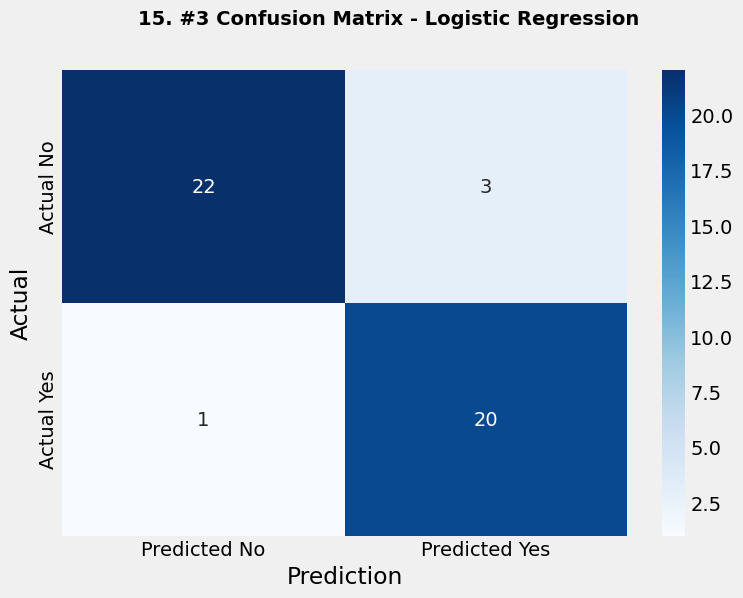

In [358]:
# Call the LogisticRegression function from the scikit-learn package
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_log = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_log)

# Evaluation
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))

print("="*60)

# Performance Metrics Detail
print("Calculation Specific Result:\n")
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #3 Confusion Matrix - Logistic Regression', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [359]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': log_model.coef_[0]
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                 Feature    Weight
6        interview_score  2.288087
4  behavioral_assessment  1.932679
3        tech_assessment  1.355319
5       coding_challenge  0.999913
1        education_level  0.088760
0       years_experience  0.049568
2                    gpa -3.456786


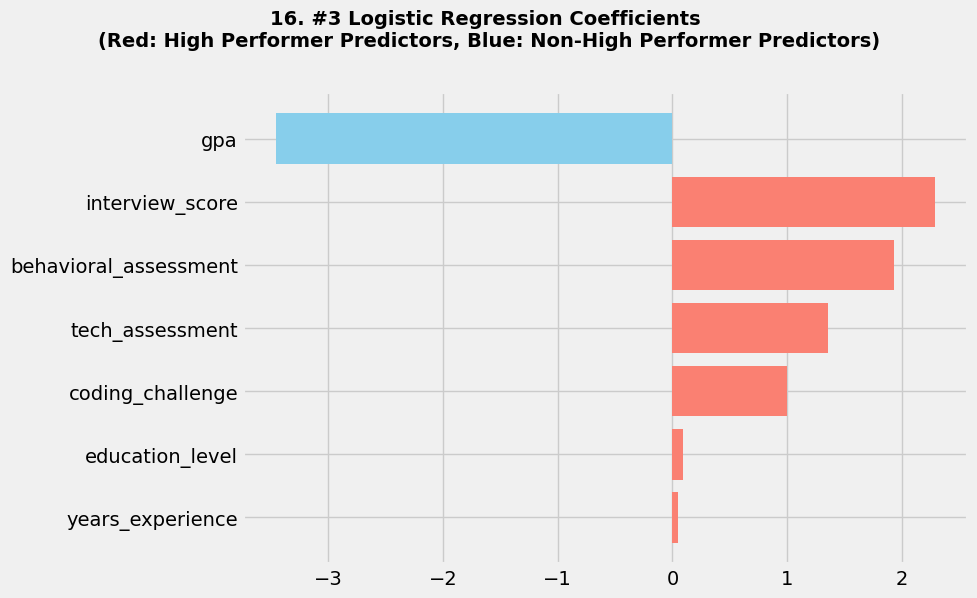

In [360]:
# Create visualisastion of logistic regression coefficients
log_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_model.coef_[0]
})

# Sort by largest absolute influence
log_importance['abs_coeff'] = log_importance['Coefficient'].abs()
log_importance = log_importance.sort_values(by='abs_coeff', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(log_importance['Feature'], log_importance['Coefficient'],
         color=(log_importance['Coefficient'] > 0).map({True: 'salmon', False: 'skyblue'}))
plt.suptitle(f'{plot_no}. #3 Logistic Regression Coefficients \n(Red: High Performer Predictors, Blue: Non-High Performer Predictors)', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [361]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.91780822 0.8630137  0.90410959 0.94520548 0.91780822]
Average Accuracy: 90.96%
Standard Deviation (Consistency): 2.68%


#### XGBoost Algorithm

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        25
           1       0.88      1.00      0.93        21

    accuracy                           0.93        46
   macro avg       0.94      0.94      0.93        46
weighted avg       0.94      0.93      0.93        46

Result Calculation Specific:

Correctly Predicted 'No' (TN): 22
Incorrectly Predicted 'No' (FP): 3
Incorrectly Predicted 'Yes' (FN): 0
Correctly Predicted 'Yes' (TP): 21


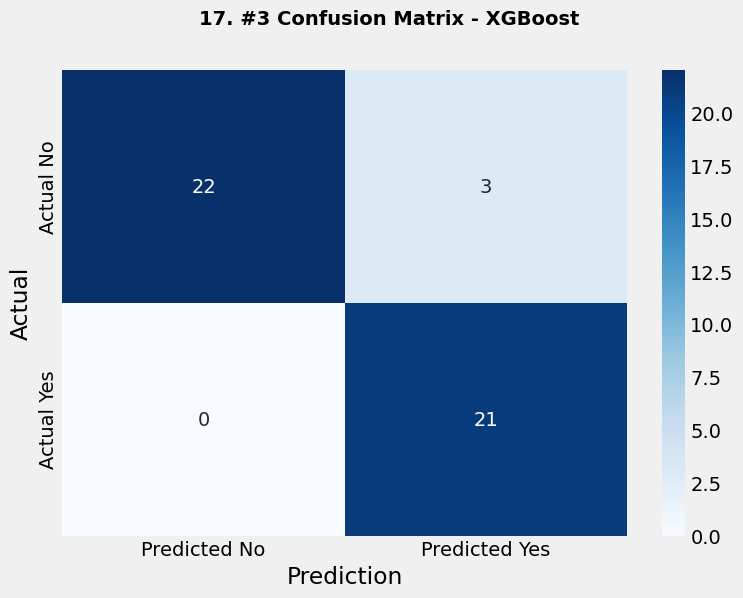

In [362]:
# Call the XGBClassifier function
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

# Training Model
xgb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

print("="*60)

# Performance Metrics Detail
print("Result Calculation Specific:\n")
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Predicted 'No' (TN): {tn}")
print(f"Incorrectly Predicted 'No' (FP): {fp}")
print(f"Incorrectly Predicted 'Yes' (FN): {fn}")
print(f"Correctly Predicted 'Yes' (TP): {tp}")

print("="*60)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.suptitle(f'{plot_no}. #3 Confusion Matrix - XGBoost', y=1, fontsize=14, fontweight='bold')
show_fig()
plot_no += 1

In [363]:
# Show the importance feature by weight
feature_weights = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Weight': xgb_model.feature_importances_
}).sort_values(by='Weight', ascending=False)
print(feature_weights)

                 Feature    Weight
6        interview_score  0.468332
4  behavioral_assessment  0.154719
0       years_experience  0.147223
1        education_level  0.092719
2                    gpa  0.085909
3        tech_assessment  0.047896
5       coding_challenge  0.003202


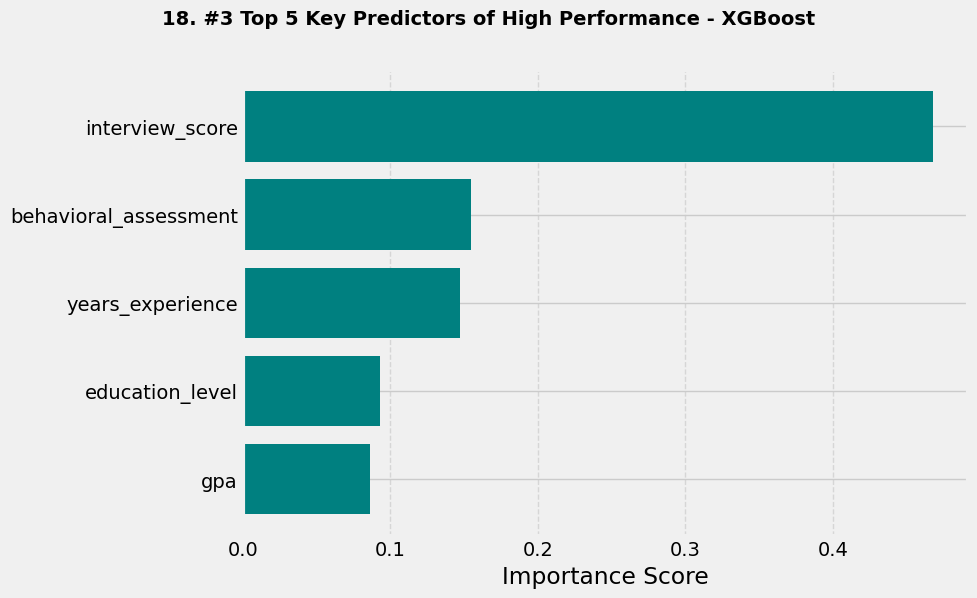

In [364]:
# Create visaulization top 5 key predictor of high performer
selected_model = xgb_model

# Taking the feature importance score
importances = selected_model.feature_importances_
feature_names = X_train_scaled.columns

# Create a DataFrame to make sorting easier
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importance = df_importance.sort_values(by='Importance', ascending=True).tail(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.suptitle(f'{plot_no}. #3 Top 5 Key Predictors of High Performance - XGBoost', y=1, fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
show_fig()
plot_no += 1

In [365]:
# Performing 5-fold cross validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)

print(f"Score for each fold: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation (Consistency): {cv_scores.std() * 100:.2f}%")

Score for each fold: [0.97260274 0.95890411 0.91780822 0.93150685 0.94520548]
Average Accuracy: 94.52%
Standard Deviation (Consistency): 1.94%


## 4 Conclusions

### 📊 **Iterative Performance Tracking**

The following table highlights how each model reacted as we refined the feature set to eliminate bias and leakage.

| Iteration | Model | Accuracy | Precision | Recall | Note |
| :--- | :--- | :---: | :---: | :---: | :--- |
| **1** | LogReg / XGBoost | 98% | 0.95 | 1.00 | **Leakage Detected** |
| **2** | **Logistic Regression** | **91%** | 0.87 | 0.95 | **Stable & Robust** |
| | XGBoost | 85% | 0.82 | 0.86 | Significant Performance Drop |
| **3** | **Logistic Regression** | **91%** | 0.87 | 0.95 | **Consistent Result** |
| | XGBoost | 93% | 0.88 | 1.00 | Volatile Recovery |

One of the most critical findings in this project was the **instability of XGBoost**. When the dominant technical features were removed in Iteration 2, XGBoost's accuracy plummeted to **85%**.

Meanwhile, **Logistic Regression** maintained a rock-solid **91% accuracy** across all subsequent iterations. This proves that for this specific dataset size, a linear model is far more reliable and less sensitive to feature adjustments than a complex tree-based model.

### **🎯 Final Selection: Logistic Regression as the Optimized Model**

Beyond the raw numbers, **Logistic Regression (Iteration 2/3)** stands out as the superior model for this analytics framework. While **XGBoost** reached a 93% accuracy, Logistic Regression offers a more balanced and reliable approach for real-world HR applications:

1.  **Reliable Accuracy vs. Overfitting:** With a small test set of 46 samples, XGBoost’s complexity often leads to "memorizing" noise. The 91% accuracy from Logistic Regression is more realistic and significantly more likely to hold up when tested against new, unseen data.
2.  **Solid Performance Metrics:** The model achieves a healthy balance between **Precision (0.87)** and **Recall (0.95)**. This ensures we capture the right talent while maintaining a high level of confidence in the predictions.
3.  **Actionable Transparency:** Logistic Regression provides clear coefficients, allowing HR leaders to understand the actual drivers of high performance.


| Comparison | **Logistic Regression (Best Model)** | **XGBoost** |
| :--- | :--- | :--- |
| **Accuracy** | **91%** (Stable & Realistic) | 93% (Prone to Overfitting) |
| **Reliability** | Highly Robust for Small Datasets | Sensitive to Data Noise |
| **Interpretability** | Clear & Actionable Insights | Complex & Hard to Explain |
| **Business Value** | Drives Strategic HR Decisions | High Predictive Power, Low Clarity |

## End of The Notebook